# Visualize EEG Artifacts and Masked Autoencoder's Masking Uncertainty

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

D:\GitHub\eeg_analysis


In [15]:
# Load some packages
import os
import gc
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
import wandb
import pprint
import numpy as np
import torch
import torchvision
from tqdm.auto import tqdm
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch
from matplotlib.gridspec import GridSpec
import scienceplots
import mpl_interactions.ipyplot as iplt
from mpl_interactions import interactive_axvline
from mpl_interactions.controller import Controls
import mpl_interactions

# custom package
from run_train import check_device_env
from run_train import set_seed
from run_train import compose_dataset
from run_train import generate_model
from train.train_script import train_script
from datasets.caueeg_script import EegToTensor, EegDropChannels
from models.utils import count_parameters

In [2]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'bicubic'
plt.rcParams["font.family"] = 'Roboto Slab' # 'NanumGothic' # for Hangul in Windows
plt.style.use('classic') 
plt.style.use('default') 
plt.style.use('default') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Roboto Slab'})
plt.rcParams["savefig.dpi"] = 1200

---

## Load and modify the pretrained network

In [3]:
timings_ = {
    "00852": [("00:04", 1.1), ("00:20", 0.5), ("00:56", 0.9), ("03:39", 2.0), ("05:07", 2.4), ("07:26", 1.8)],
    "00684": [("01:35", 6.0), ("01:49", 19.7)],
    "00096": [("00:12", 11.6), ("01:41", 2.7), ("02:23", 2.4), ("03:21", 5.9), ("04:18", 2.0), ("09:18", 20.7)],
    "00366": [("03:02", 6.9), ("06:11", 1.4), ("06:28", 2.5), ("06:42", 1.8), ("06:48", 1.7), 
              ("07:08", 0.4), ("08:39", 2.6), ("08:47", 1.9), ("15:22", 8.1)],
    "00478": [("00:02", 11.2), ("00:19", 7.2), ("06:59", 2.2), ("07:04", 0.8), ("10:14", 2.2)],
    "00275": [("02:37", 2.6), ("04:36", 2.2), ("09:35", 2.8)],
    "00338": [("00:00", 12.8), ("00:34", 5.9)],
    "00469": [("05:32", 18.1), ("05:55", 11.1), ("06:12", 8.1)],
    "00661": [("00:02", 2.5), ("01:01", 4.3), ("03:04", 12.8), ("03:26", 5.7), ("08:33", 7.1)],
    "00294": [("00:17", 1.9), ("01:16", 2.4)],
}

timings = {}
for k, v in timings_.items():
    timings[k] = []
    for time, duration in v:
        timings[k].append((int(time[:2]) * 60 + int(time[3:]), duration))

pprint.pprint(timings)

{'00096': [(12, 11.6),
           (101, 2.7),
           (143, 2.4),
           (201, 5.9),
           (258, 2.0),
           (558, 20.7)],
 '00275': [(157, 2.6), (276, 2.2), (575, 2.8)],
 '00294': [(17, 1.9), (76, 2.4)],
 '00338': [(0, 12.8), (34, 5.9)],
 '00366': [(182, 6.9),
           (371, 1.4),
           (388, 2.5),
           (402, 1.8),
           (408, 1.7),
           (428, 0.4),
           (519, 2.6),
           (527, 1.9),
           (922, 8.1)],
 '00469': [(332, 18.1), (355, 11.1), (372, 8.1)],
 '00478': [(2, 11.2), (19, 7.2), (419, 2.2), (424, 0.8), (614, 2.2)],
 '00661': [(2, 2.5), (61, 4.3), (184, 12.8), (206, 5.7), (513, 7.1)],
 '00684': [(95, 6.0), (109, 19.7)],
 '00852': [(4, 1.1), (20, 0.5), (56, 0.9), (219, 2.0), (307, 2.4), (446, 1.8)]}


In [4]:
model_name = 'yap6fgxc' # boej8vuk yap6fgxc p02vsovi | 3du3h4yl bco01cyz
target_datasets = ['val'] # ['train', 'val']

use_wandb = True
device = 'cuda:0'
model_path = 'local/checkpoint/'

In [5]:
print('PyTorch version:', torch.__version__)
device = torch.device(device if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 2.1.2+cu118
cuda is available.


In [6]:
# load pretrained configurations
path = os.path.join(model_path, model_name.split(',')[-1], 'checkpoint.pt')
try:
    ckpt = torch.load(path, map_location=device)
    config = ckpt['config']
except Exception as e:
    print(e)
    print(f'- checkpoint cannot be opened: {path}')
pprint.pprint(config)

{'EKG': 'O',
 '_target_': 'models.mae_1d_artifact.mae_1d_art_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([71.3079], device='cuda:0'),
 'age_std': tensor([9.6942], device='cuda:0'),
 'art_dropout': 0.1,
 'art_loss_type': 'mse',
 'art_out_activation': 'none',
 'art_patch_usage': {'type': 'drop_high', 'value': 0.5},
 'art_use_age': 'no',
 'awgn': 0.03,
 'awgn_age': 0.001,
 'base_lr': 0.0002346826826397242,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 5120,
 'crop_multiple': 8,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.1,
 'fc_stages': 2,
 'file_format': 'memmap',
 'global_pool': True,
 'in_channels': 20,
 'input_norm': 'datapoint',
 'iterations': 39062,
 'latency': 2000,
 'layer_wise_lr': True,
 'l

In [7]:
# generate the model
config["device"] = device
model = generate_model(config).to(device)

# load model
model.load_state_dict(ckpt["model_state"])
model.requires_grad_(False)
model = model.eval()
model.art_net

Sequential(
  (0): Conv1d(20, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (1): BatchNorm1d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
  (2): GELU(approximate='none')
  (3): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (4): BatchNorm1d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
  (5): GELU(approximate='none')
  (6): Conv1d(64, 64, kernel_size=(9,), stride=(2,), padding=(4,))
  (7): BatchNorm1d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
  (8): GELU(approximate='none')
  (9): AdaptiveAvgPool1d(output_size=1)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=64, out_features=32, bias=False)
  (12): Dropout(p=0.1, inplace=False)
  (13): BatchNorm1d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
  (14): GELU(approximate='none')
  (15): Linear(in_features=32, out_features=1, bias=True)
  (16): Identity()
)

---

## Generate the DataLoader

In [8]:
config['task']
config.pop('cwd', 0)
config['ddp'] = False
config['minibatch'] = 1
config['crop_multiple'] = 1
config['test_crop_multiple'] = 1
config['crop_timing_analysis'] = True
config['eval'] = True
config['device'] = device

config["task"] = 'abnormal'  # annotations were written with respect to the CAUEEG-Abnormal task data
train_loader, val_loader, test_loader, _ = compose_dataset(config)
signal_header = [channel.split('-')[0] for i, channel in enumerate(config["signal_header"])]

In [9]:
with torch.no_grad():
    for sample in val_loader:
        if sample["serial"][0] in timings.keys():
            print(sample)
            ct = sample["crop_timing"][0]
            break

{'serial': ['00661'], 'age': tensor([61.]), 'symptom': [['tga']], 'class_name': ['Abnormal'], 'class_label': tensor([1]), 'signal': tensor([[[-140., -143., -143.,  ...,  -27.,  -24.,  -21.],
         [  -3.,   -6.,  -10.,  ...,   34.,   35.,   35.],
         [  17.,   15.,   13.,  ...,    8.,    6.,    3.],
         ...,
         [  16.,   10.,    5.,  ...,   -9.,   -7.,   -4.],
         [  19.,   13.,   11.,  ...,  -13.,  -14.,  -14.],
         [ 181.,  110.,  115.,  ...,   17.,   12.,   10.]]]), 'crop_timing': [136501]}


In [10]:
print("Previous Transform")
print(val_loader.dataset.transform)
print("---" * 10)

# skip the first transform (RandomCrop)
for loader in [train_loader, val_loader, test_loader]:
    loader.dataset.transform = torchvision.transforms.Compose([
        *loader.dataset.transform.transforms[1:]
    ])

print("Modified Transform")
print(val_loader.dataset.transform)

Previous Transform
Compose(
    EegRandomCrop(crop_length=5120, length_limit=10000000, multiple=1, latency=2000, segment_simulation=False, return_timing=True, reject_events=False)
    EegDropChannels(drop_index=[20])
    EegToTensor()
)
------------------------------
Modified Transform
Compose(
    EegDropChannels(drop_index=[20])
    EegToTensor()
)


In [11]:
with torch.no_grad():
    for sample in val_loader:
        if sample["serial"][0] in timings.keys():
            print(sample["signal"][:, :, ct:ct + config["crop_length"]])
            break

tensor([[[-140., -143., -143.,  ...,  -27.,  -24.,  -21.],
         [  -3.,   -6.,  -10.,  ...,   34.,   35.,   35.],
         [  17.,   15.,   13.,  ...,    8.,    6.,    3.],
         ...,
         [  16.,   10.,    5.,  ...,   -9.,   -7.,   -4.],
         [  19.,   13.,   11.,  ...,  -13.,  -14.,  -14.],
         [ 181.,  110.,  115.,  ...,   17.,   12.,   10.]]])


---

## Compute uncertainty

In [12]:
interval = 4  # speed control
results = {}

with torch.no_grad():
    for sample in val_loader:
        serial = sample["serial"][0]
        if serial in timings.keys():
            values = timings[serial]
            L = sample["signal"][0].shape[-1]
            count = torch.zeros((L,))
            score = torch.zeros((L,))

            for t in tqdm(range(0, L - config["crop_length"], interval), desc="Crops", leave=False):
                s = deepcopy(sample)
                s["signal"] = s["signal"][:, :, t:t + config["crop_length"]]
                config["preprocess_test"](s)    
                out = model.forward_artifact(s["signal"], s["age"]).cpu()
                
                out = torch.nn.functional.interpolate(out.reshape(1, 1, 1, -1), 
                                                      size=(1, config["crop_length"], ), mode="nearest")
                out = out.squeeze()
                count[t:t + config["crop_length"]] += 1
                score[t:t + config["crop_length"]] += out
                
            results[serial] = score / (count + 1e-8)

Crops:   0%|          | 0/46970 [00:00<?, ?it/s]

Crops:   0%|          | 0/45870 [00:00<?, ?it/s]

Crops:   0%|          | 0/44370 [00:00<?, ?it/s]

Crops:   0%|          | 0/26170 [00:00<?, ?it/s]

Crops:   0%|          | 0/22720 [00:00<?, ?it/s]

Crops:   0%|          | 0/45120 [00:00<?, ?it/s]

Crops:   0%|          | 0/42070 [00:00<?, ?it/s]

Crops:   0%|          | 0/44720 [00:00<?, ?it/s]

Crops:   0%|          | 0/44020 [00:00<?, ?it/s]

Crops:   0%|          | 0/25870 [00:00<?, ?it/s]

---

## Visualize

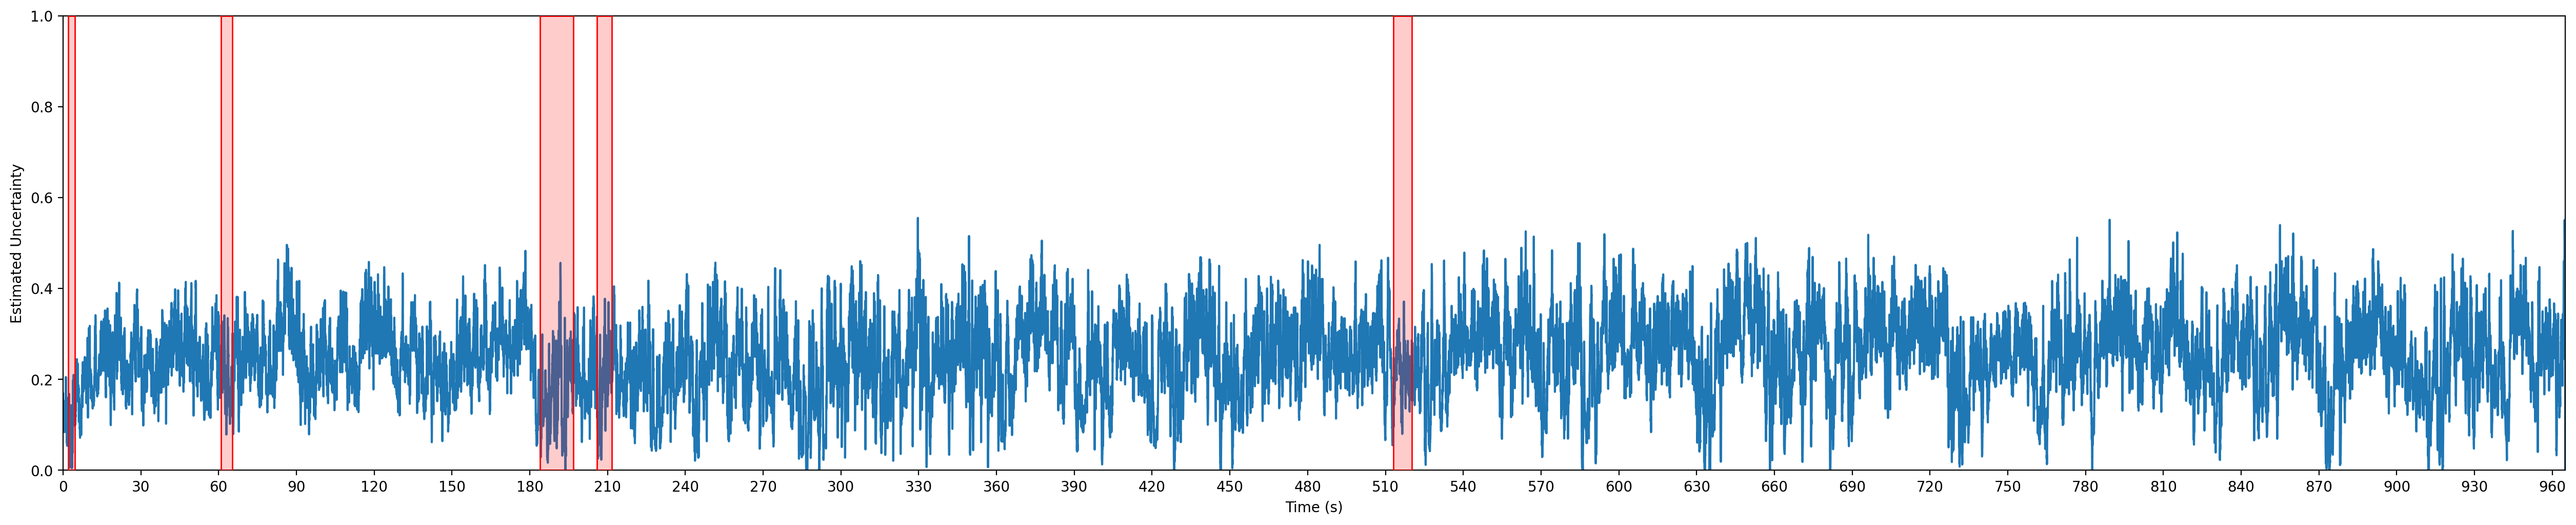

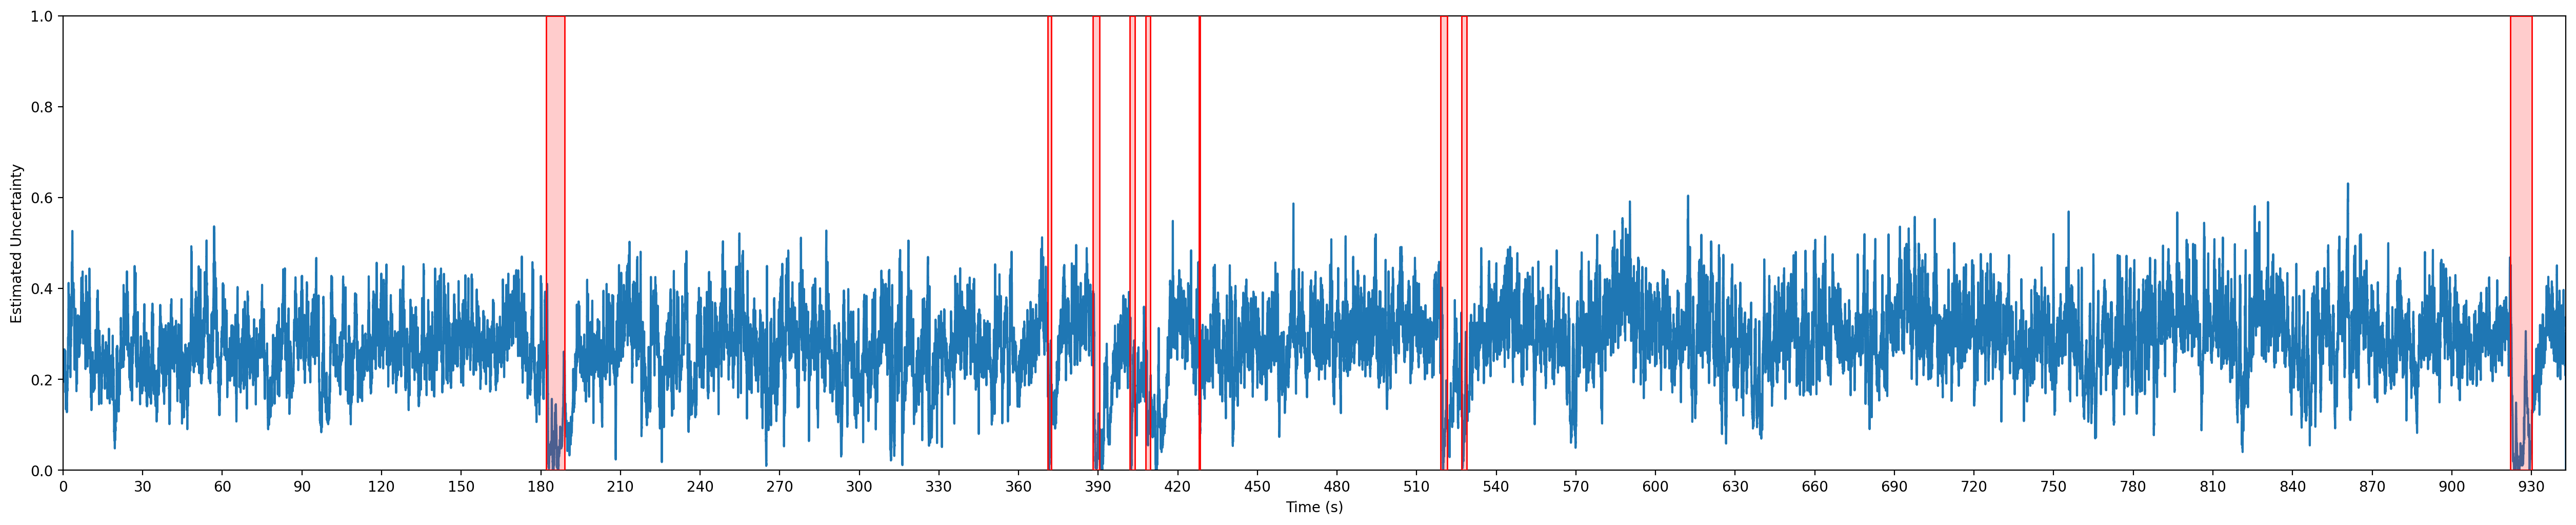

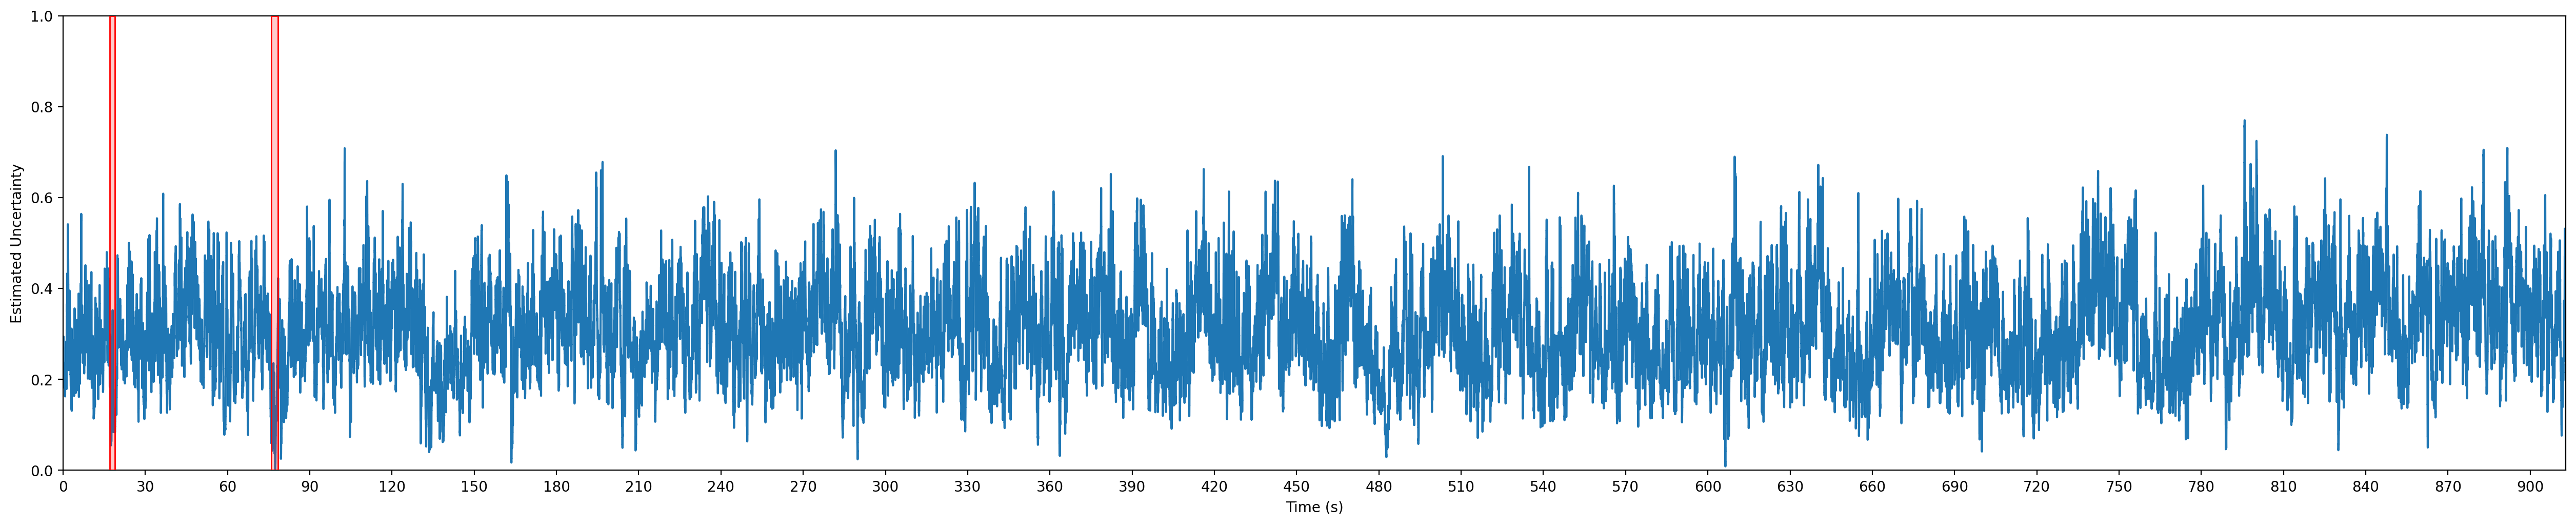

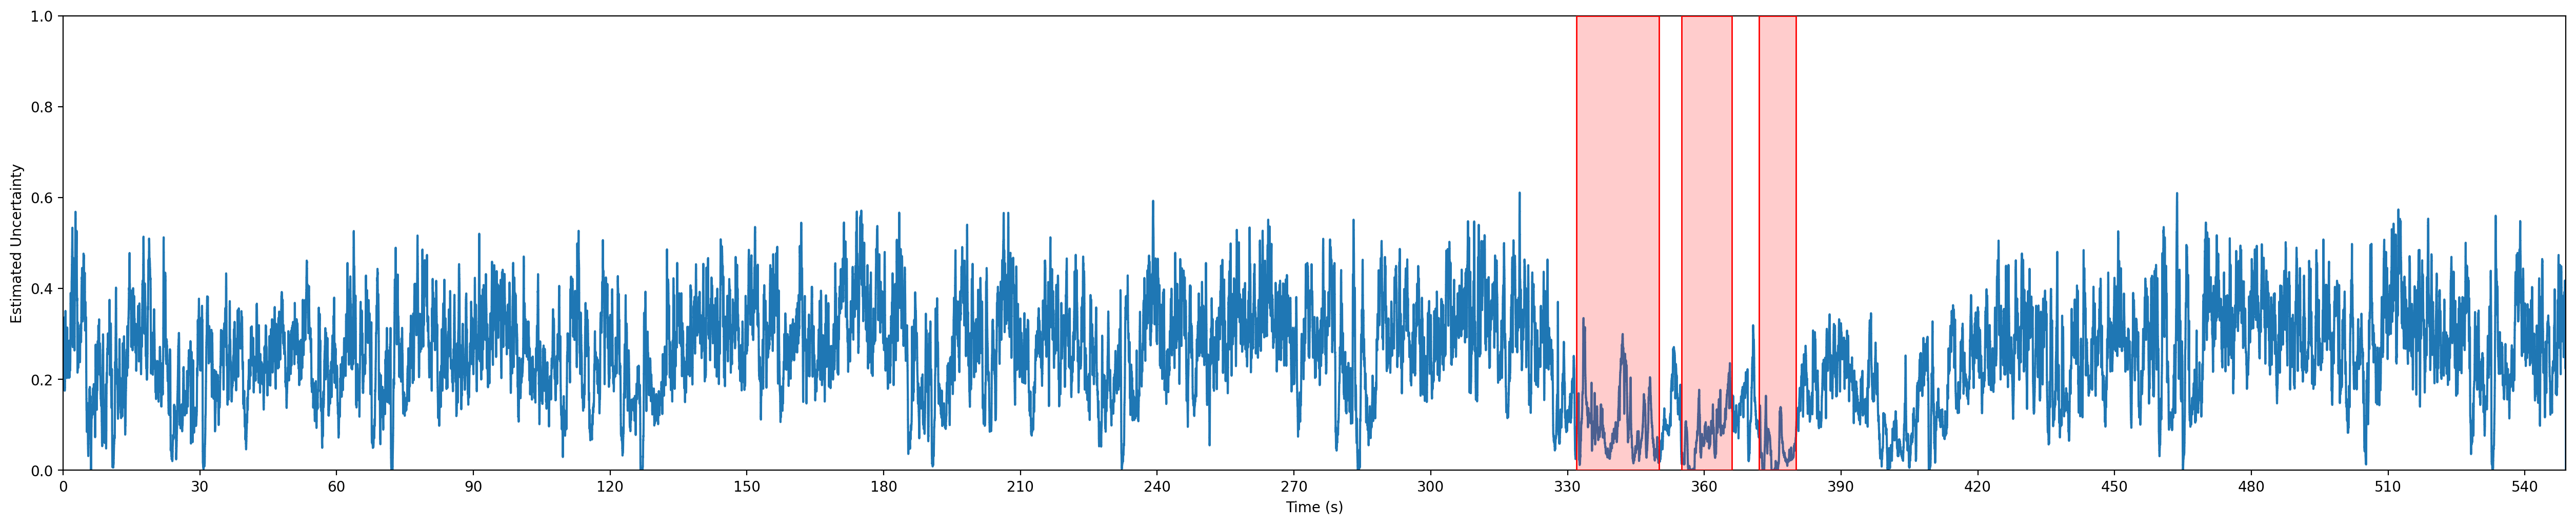

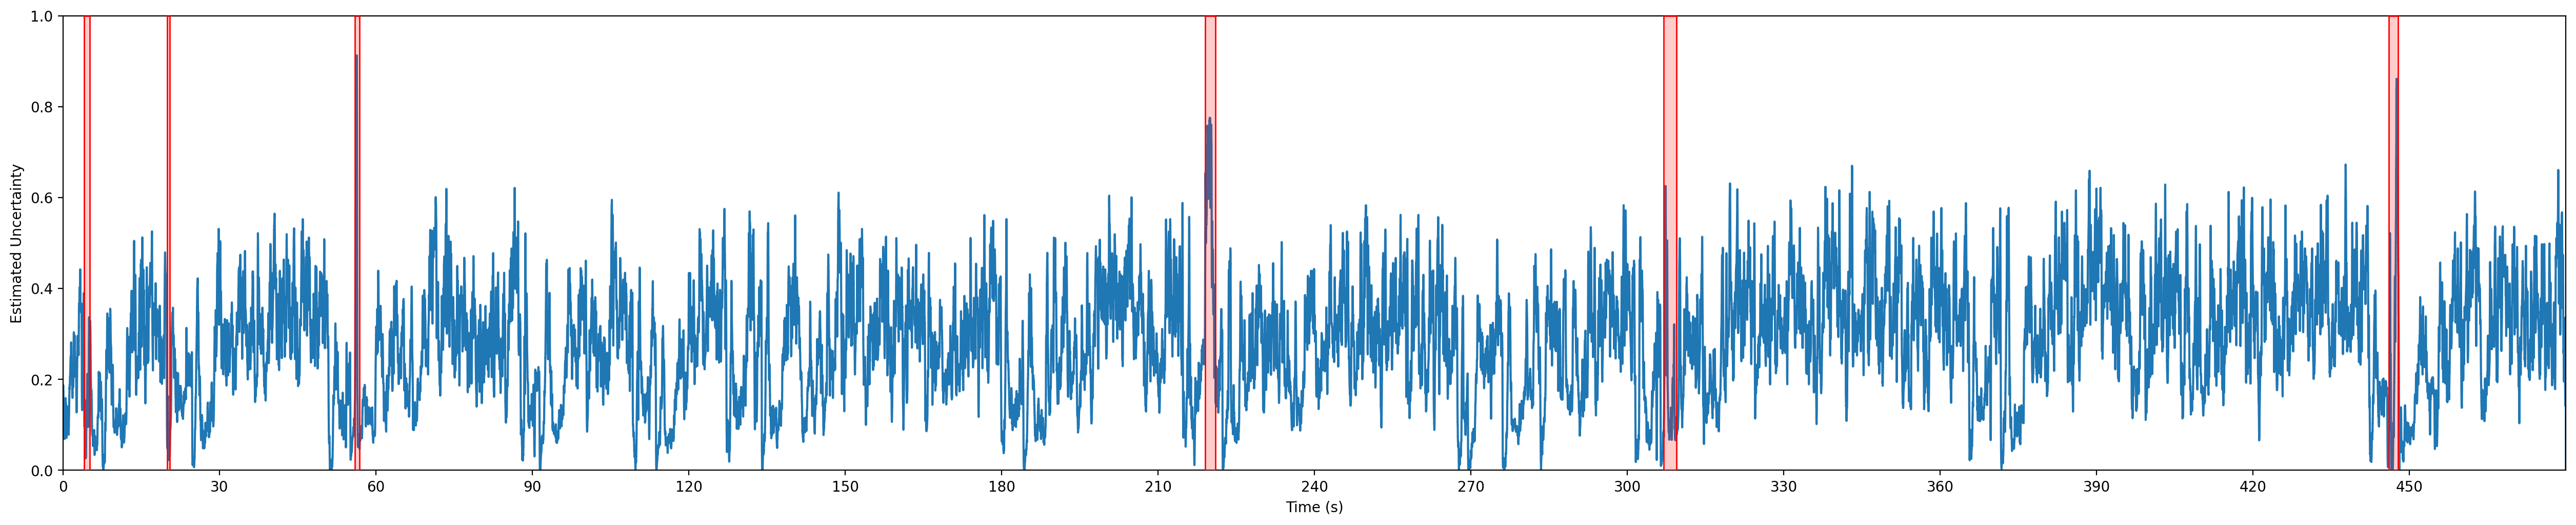

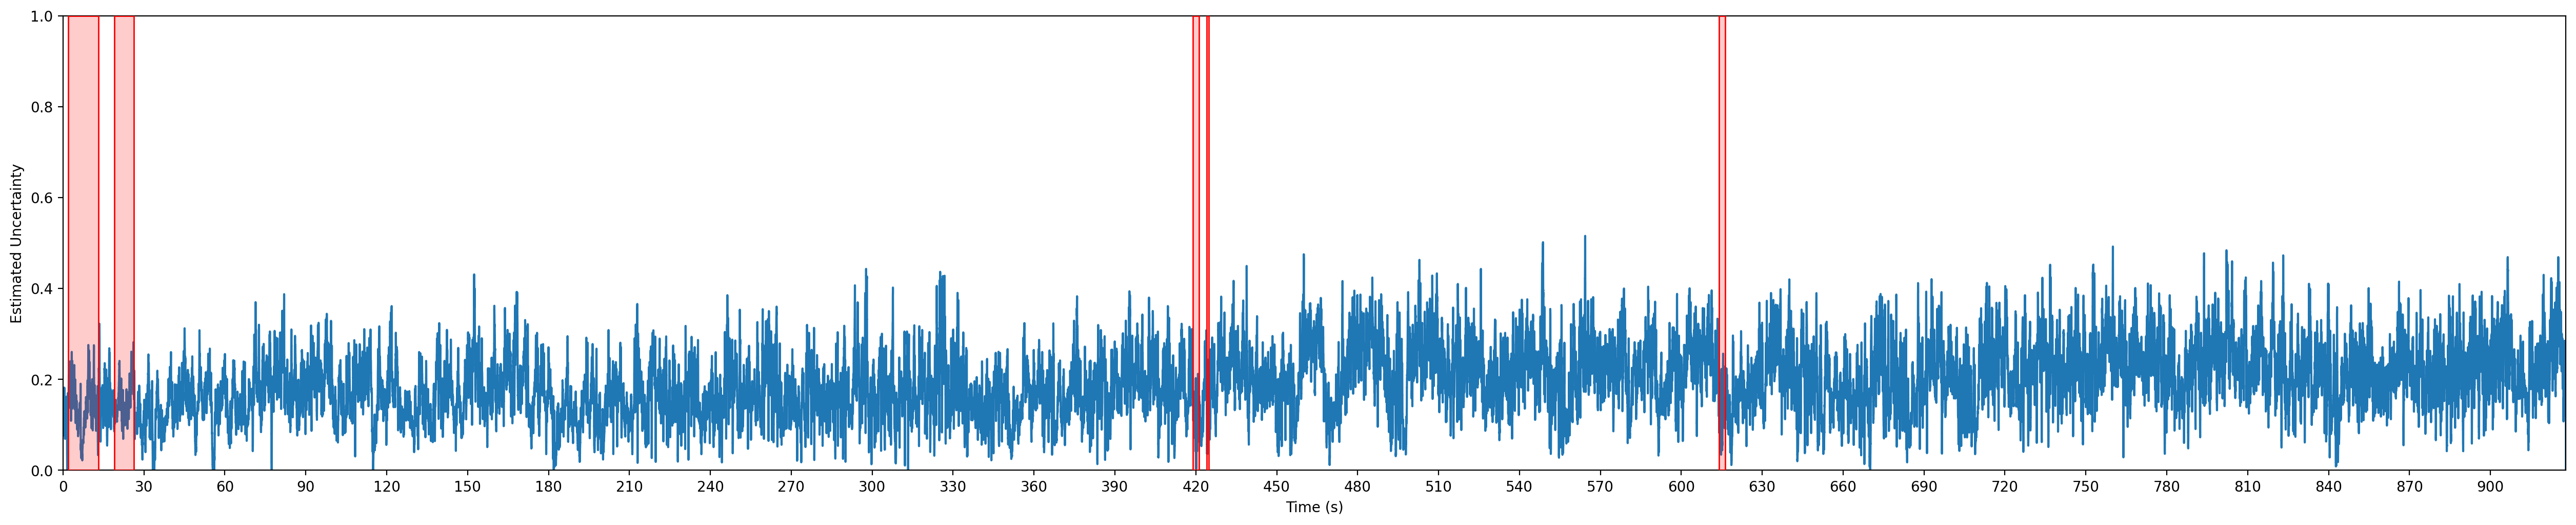

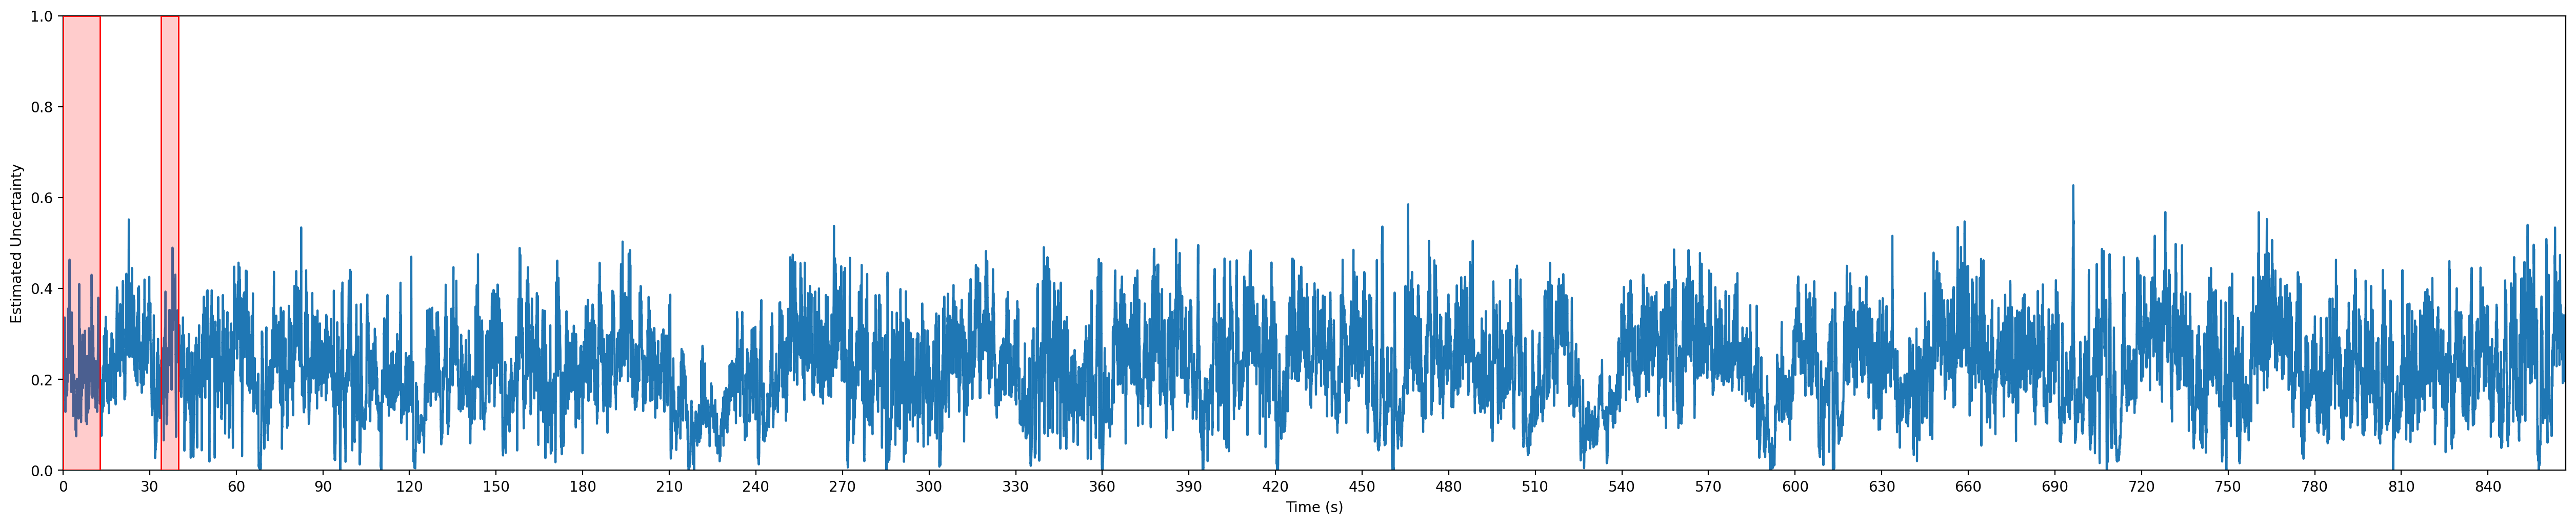

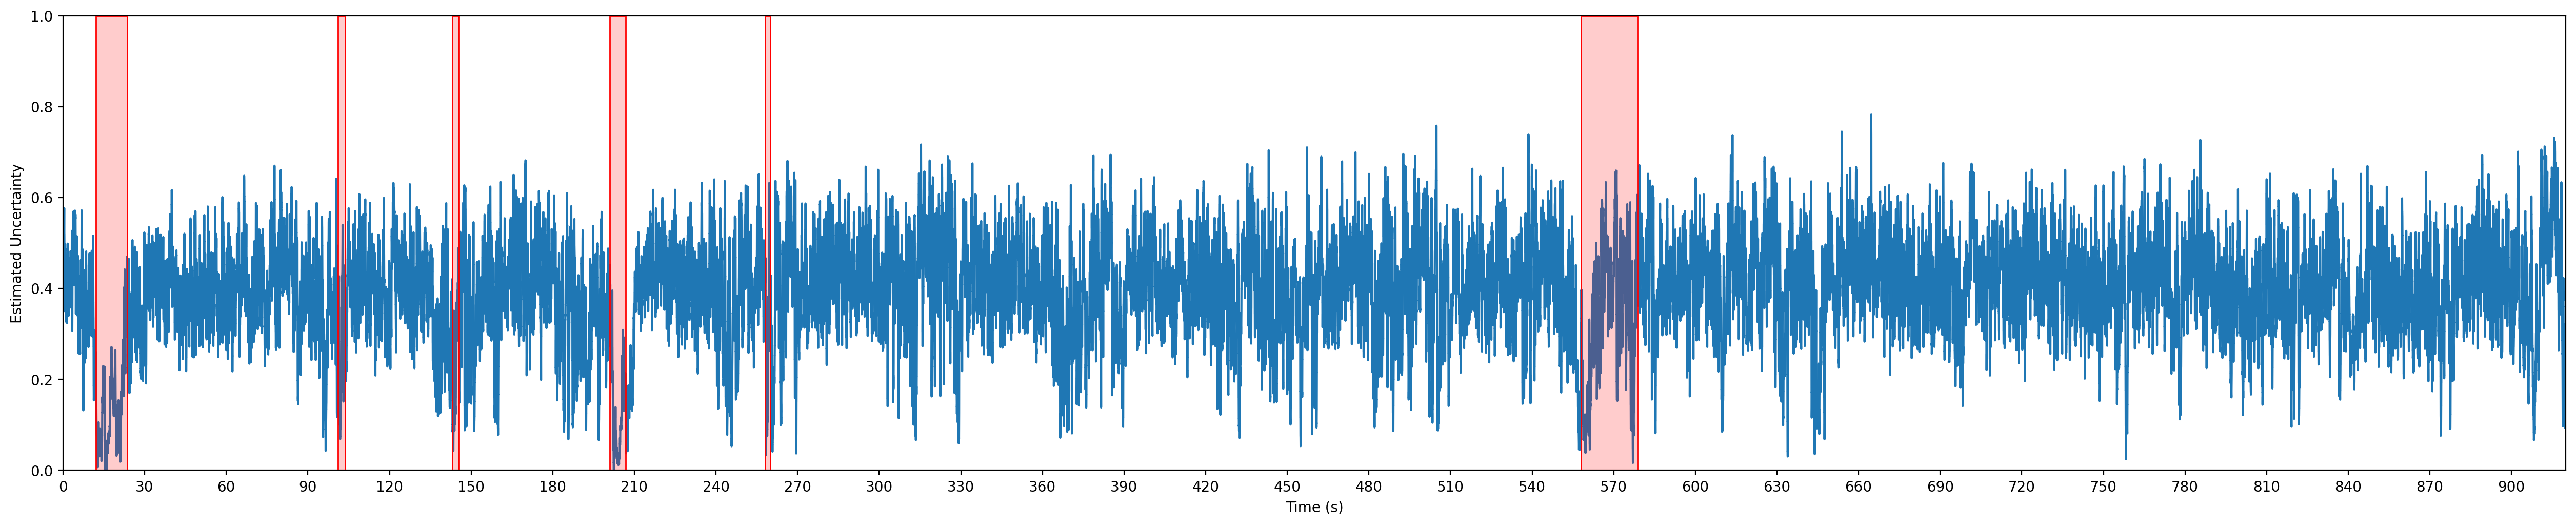

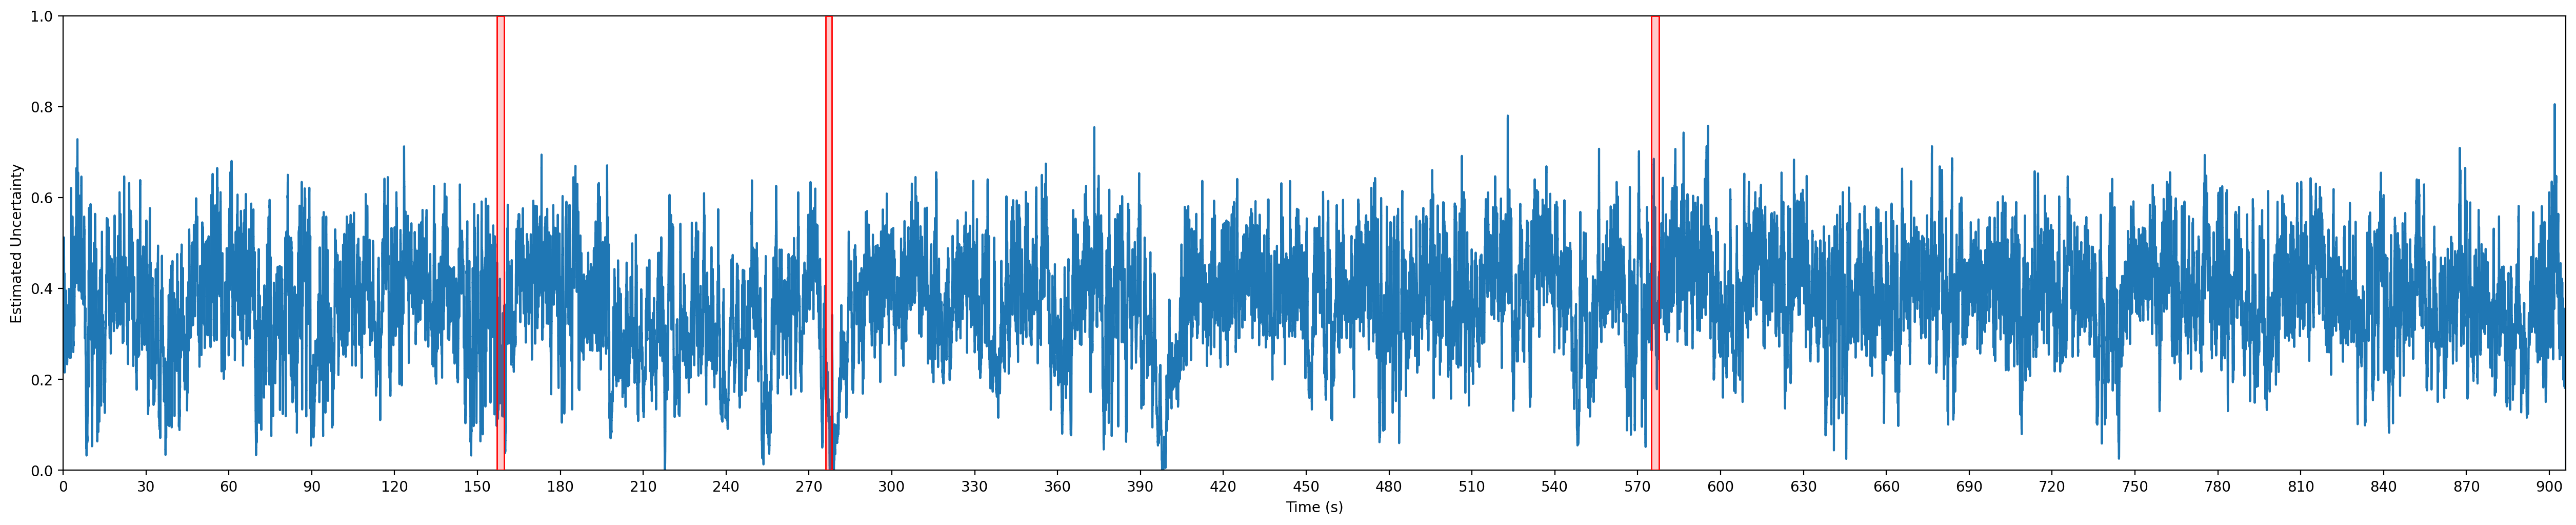

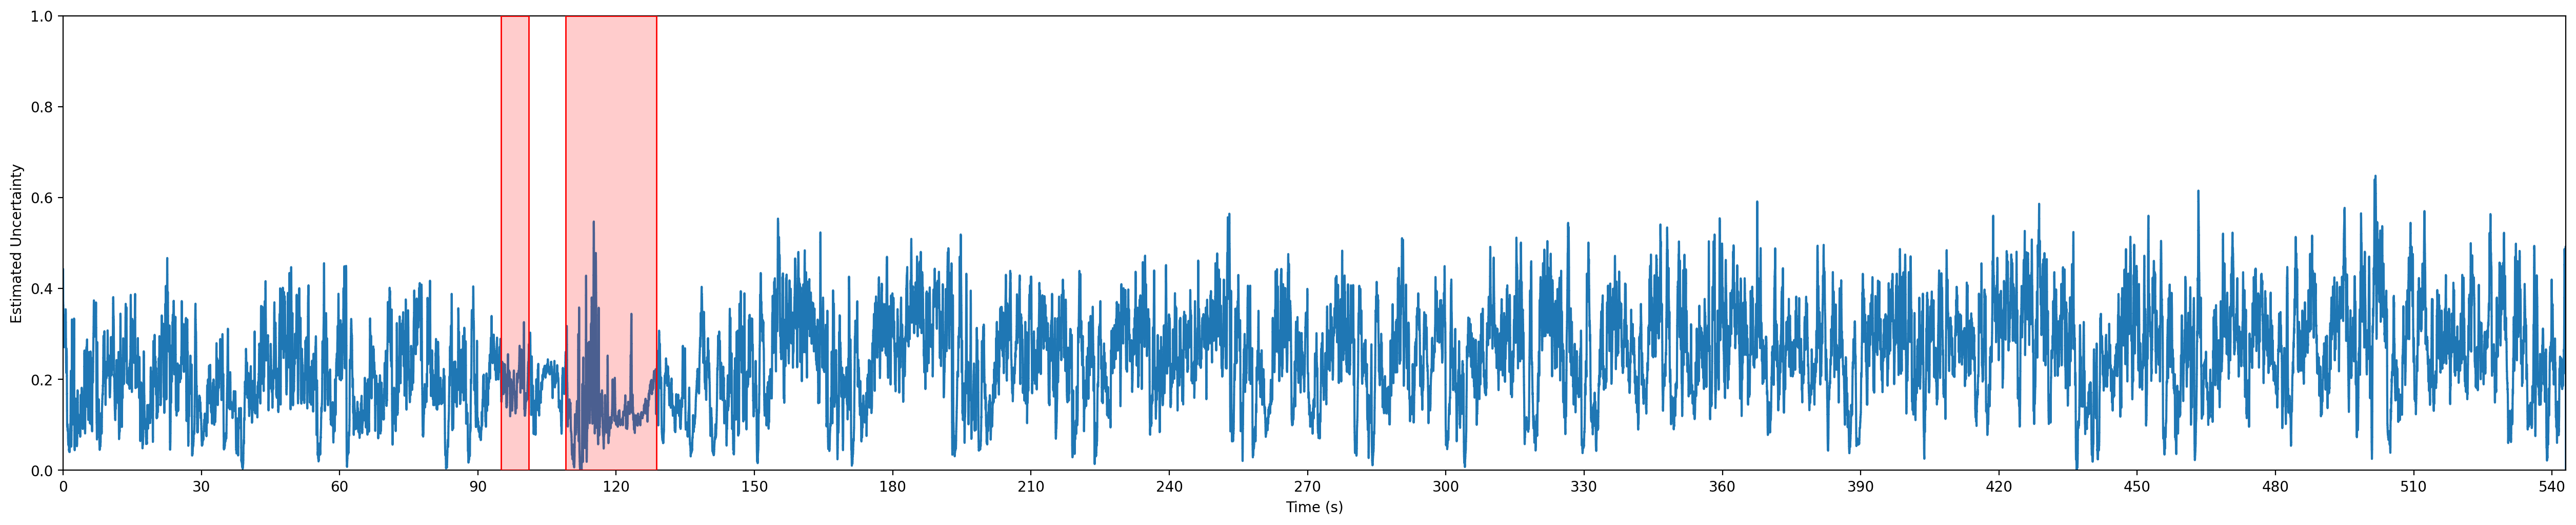

In [13]:
with plt.style.context(['ieee', 'science', 'default']):  # science, ieee, default, fivethirtyeight
    # plt.rcParams.update({'font.family': 'Roboto Slab'})
    
    for serial in results.keys():
        fig, ax = plt.subplots(1, 1, figsize=(25, 5), constrained_layout=True)

        r = results[serial].numpy()
        ax.plot(r)
        sample_rate = config["sampling_rate"]

        for start, duration in timings[serial]:
            bb = mtransforms.Bbox.from_bounds(x0=round(start*sample_rate), y0=0, 
                                              width=round(duration*sample_rate), height=1)
            fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="square,pad=0")
            fancy.set(edgecolor="red", facecolor=(1, 0, 0, 0.2), zorder=10, )
            ax.add_patch(fancy)
        
        x_ticks = np.arange(0, r.shape[0], sample_rate * 30)
        x_labels = [f"{round(tick / sample_rate)}" for tick in x_ticks]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0, r.shape[0])
        ax.set_ylim(0, 1.0)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Estimated Uncertainty')

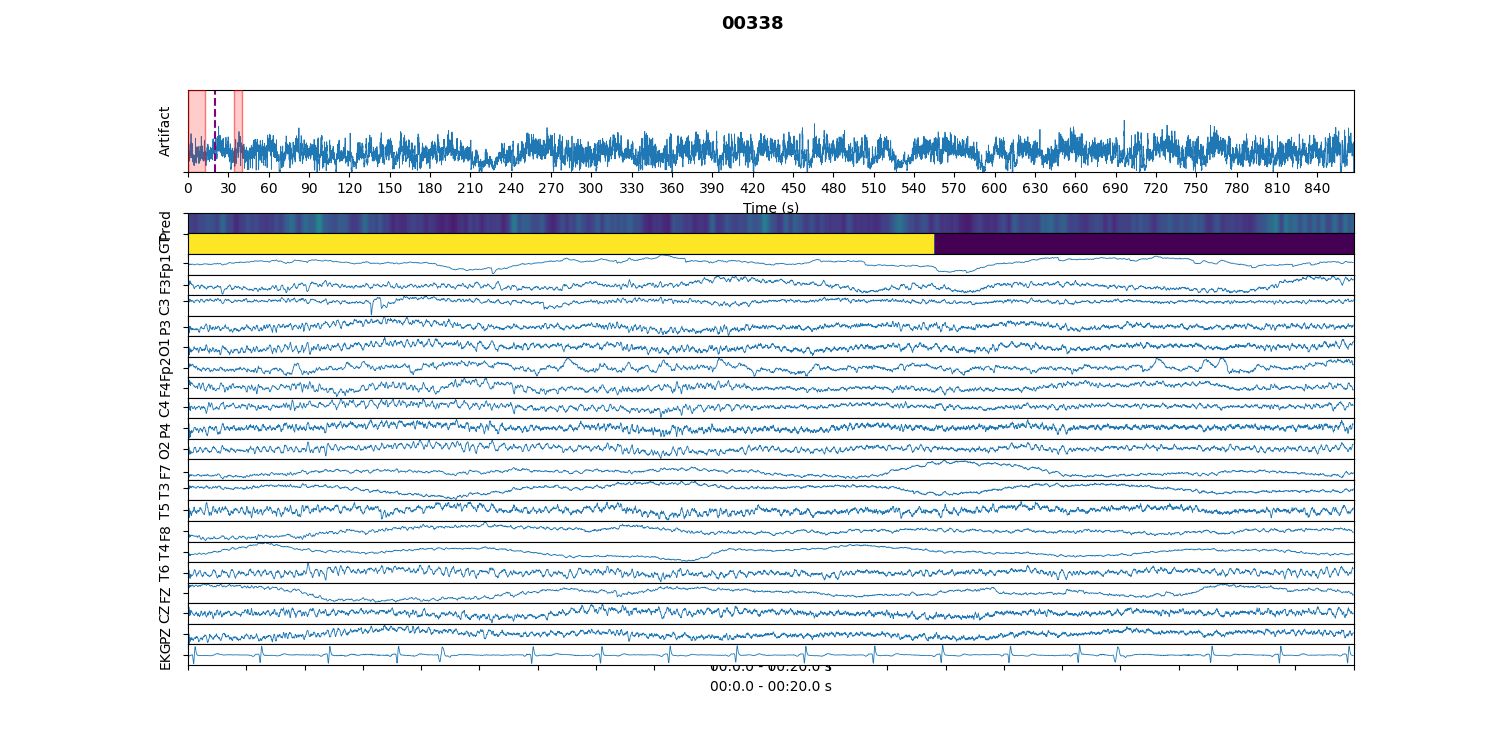

In [29]:
%matplotlib ipympl
target_serial = [*timings.keys()][6]  # 0, 7
duration = 4000

def f1(signal, start, duration):
    return signal[start: start + duration]
    
def f2(result, start, duration):
    return np.tile(result[start: start + duration], (50, 1))

def f3(supervised, start, duration):
    return np.tile(supervised[start: start + duration], (50, 1))

def f4(start, duration):
    t = start
    start_time = f"{int((t / sample_rate) // 60):02d}:{(t / sample_rate) % 60:02.1f}"
    t = start + duration
    end_time = f"{int((t / sample_rate) // 60):02d}:{(t / sample_rate) % 60:02.1f}"
    return start_time + " - " + end_time + " s"

def f5(signal, avg):
    if avg:
        signal = np.convolve(signal, np.ones(avg), 'same') / avg
    return signal

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

with plt.style.context(['ieee', 'science', 'default']):  # science, ieee, default, fivethirtyeight
    # plt.rcParams.update({'font.family': 'Roboto Slab'})

    for sample in val_loader:
        serial = sample["serial"][0]
        if serial == target_serial:
            signal = sample["signal"][0].cpu().numpy()
            sample_rate = config["sampling_rate"]
            C, L = signal.shape
            r = results[serial].numpy()
                
            fig = plt.figure(num=1, clear=True, figsize=(30, 15))
            fig.subplots_adjust(hspace=0)
            fig.tight_layout()
            gs = GridSpec(nrows=C + 8, ncols=1)
            ctrls = Controls(start=np.arange(0, L - duration), avg=np.arange(0, 400))
            display(ctrls)

            ax = fig.add_subplot(gs[:4])
            iplt.plot(partial(f5, signal=r), ax=ax, lw=0.6, controls=ctrls["avg"])
            for s, d in timings[serial]:
                bb = mtransforms.Bbox.from_bounds(x0=round(s*sample_rate), y0=0, 
                                                  width=round(d*sample_rate), height=1)
                fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="square,pad=0")
                fancy.set(edgecolor=(1, 0, 0, 0.5), facecolor=(1, 0, 0, 0.2), zorder=30, )
                ax.add_patch(fancy)
            mpl_interactions.interactive_axvline(x=ctrls["start"], ymin=0, ymax=1, ax=ax, 
                                                 color='purple', controls=ctrls["start"], ls="--")
            mpl_interactions.interactive_axvline(x=lambda start: start + duration, ymin=0, ymax=1, ax=ax, 
                                                 color='purple', controls=ctrls["start"], ls="--")
            x_ticks = np.arange(0, r.shape[0], sample_rate * 30)
            x_labels = [f"{round(tick / sample_rate)}" for tick in x_ticks]
            ax.set_xlim(0, r.shape[0])
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels)
            ax.set_xlabel('Time (s)')
            ax.set_ylim(0, 1.0)
            ax.set_yticks([0])
            ax.set_yticklabels([])
            ax.set_ylabel("Artifact")
            
            ax = fig.add_subplot(gs[6])
            iplt.imshow(partial(f2, result=r, duration=duration), aspect="auto",
                        alpha=1.0, ax=ax, controls=ctrls["start"], vmin=0, vmax=1)
            ax.set_xticklabels([])
            ax.set_yticks([0])
            ax.set_yticklabels([])
            ax.set_ylabel("Pred")

            ax = fig.add_subplot(gs[7])
            supervised = np.zeros_like(results[serial])
            for s, d in timings[serial]:
                supervised[round(s*sample_rate):round((s + d)*sample_rate)] = 1            
            iplt.imshow(partial(f3, supervised=supervised, duration=duration), aspect="auto",
                        alpha=1.0, ax=ax, controls=ctrls["start"], vmin=0, vmax=1)
            ax.set_xticklabels([])
            ax.set_yticks([0])
            ax.set_yticklabels([])
            ax.set_ylabel("GT")

            for c in range(C):
                ax = fig.add_subplot(gs[c + 8])
                iplt.plot(partial(f1, signal=signal[c], duration=duration), 
                          ax=ax, controls=ctrls["start"], lw=0.6)

                ax.set_xlim(0, duration)
                ax.set_ylabel(signal_header[c])
                mpl_interactions.interactive_xlabel(xlabel=partial(f4, duration=duration),
                                                    controls=ctrls["start"])
                ax.set_xticks(np.arange(round(duration / sample_rate) + 1) * sample_rate)
                ax.set_xticklabels([])
                # ax.tick_params(axis='x', width=0.1, length=0.1)
                ax.set_yticks([0])
                ax.set_yticklabels([])
                
            fig.suptitle(serial, fontsize=13, fontweight='semibold')

    plt.show()